In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/MyDrive/git_data

/content/drive/MyDrive/git_data


In [65]:
import numpy as np
from numpy import concatenate
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error 

In [4]:
train_store = pd.read_csv("train_store.csv")
test_store = pd.read_csv("test_store.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [61]:
# train_store2 = pd.DataFrame(train_store, index=(str(pd.to_datetime(train_store[['Day', 'Month', 'Year']]))))
train_store['date'] = pd.to_datetime(train_store[['Day', 'Month', 'Year']], format='%Y%m%d')
train_store['date'] = train_store.date.dt.strftime('%Y-%m-%d')
train_store2 = train_store.set_index(['date'])
train_store2.head()

,Unnamed: 0,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,0,1,5,5263,555,1,1,0,1,2015,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2015-07-31,1,2,5,6064,625,1,1,0,1,2015,...,9.702400,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2015-07-31,2,3,5,8314,821,1,1,0,1,2015,...,10.126675,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2015-07-31,3,4,5,13995,1498,1,1,0,1,2015,...,9.342457,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
2015-07-31,4,5,5,4822,559,1,1,0,1,2015,...,8.626118,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [ ]:
train_store2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 844338 entries, 2015-07-31 to 2013-01-01
Data columns (total 23 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Unnamed: 0                 844338 non-null  int64  
 1   Store                      844338 non-null  int64  
 2   DayOfWeek                  844338 non-null  int64  
 3   Sales                      844338 non-null  int64  
 4   Customers                  844338 non-null  int64  
 5   Open                       844338 non-null  int64  
 6   Promo                      844338 non-null  int64  
 7   StateHoliday               844338 non-null  int64  
 8   SchoolHoliday              844338 non-null  int64  
 9   Year                       844338 non-null  int64  
 10  Month                      844338 non-null  int64  
 11  Day                        844338 non-null  int64  
 12  WeekOfYear                 844338 non-null  int64  
 13  SalePerCustomer      

In [ ]:
train_store2.isna().sum()

Unnamed: 0                   0
Store                        0
DayOfWeek                    0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
Year                         0
Month                        0
Day                          0
WeekOfYear                   0
SalePerCustomer              0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [ ]:
test_store.head()

,Unnamed: 0,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,WeekOfYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,0,1,1,4,1.0,1,0,0,2015,9,...,38,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,2,3,4,1.0,1,0,0,2015,9,...,38,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,2,3,7,4,1.0,1,0,0,2015,9,...,38,a,c,24000.0,4.0,2013.0,0,0.0,0.0,0
3,3,4,8,4,1.0,1,0,0,2015,9,...,38,a,a,7520.0,10.0,2014.0,0,0.0,0.0,0
4,4,5,9,4,1.0,1,0,0,2015,9,...,38,a,c,2030.0,8.0,2000.0,0,0.0,0.0,0


In [8]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    return rmse, mae, mse

def pre_processing(df):
    #droping the auction id since it has no value for the train
    try:
      df.drop('Unnamed: 0', axis=1, inplace=True)
    except:
      pass 

    # numr_col = pre.get_numerical_columns(df) 
    # categorical_column = pre.get_categorical_columns(df)
    numerical_column = df.select_dtypes(exclude="object").columns.tolist()
    categorical_column = df.select_dtypes(include="object").columns.tolist()

    # Get column names have less than 10 more than 2 unique values
    to_one_hot_encoding = [col for col in categorical_column if df[col].nunique() <= 10 and df[col].nunique() > 2]
    one_hot_encoded_columns = pd.get_dummies(df[to_one_hot_encoding])
    df = pd.concat([df, one_hot_encoded_columns], axis=1)

    
    df.drop(categorical_column, axis=1, inplace=True)
    X = df.drop(['Customers', 'Sales', 'SalePerCustomer'], axis = 1) 
    col_name = df.columns.tolist()
    y=df.Sales
    frames = [X, y]
    result = pd.concat(frames, axis=1, join='inner')


    return result, col_name

In [62]:
X, col_name = pre_processing(train_store2)

In [ ]:
X

,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,...,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Sales
date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,1,1,0,1,2015,7,31,31,...,1,0,1,0,0,1,0,0,0,5263
2015-07-31,2,5,1,1,0,1,2015,7,31,31,...,0,0,1,0,0,0,0,1,0,6064
2015-07-31,3,5,1,1,0,1,2015,7,31,31,...,0,0,1,0,0,0,0,1,0,8314
2015-07-31,4,5,1,1,0,1,2015,7,31,31,...,1,0,0,0,1,1,0,0,0,13995
2015-07-31,5,5,1,1,0,1,2015,7,31,31,...,0,0,1,0,0,1,0,0,0,4822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-01-01,682,2,1,0,1,1,2013,1,1,1,...,0,0,1,0,0,1,0,0,0,3375
2013-01-01,733,2,1,0,1,1,2013,1,1,1,...,0,0,0,1,0,1,0,0,0,10765
2013-01-01,769,2,1,0,1,1,2013,1,1,1,...,0,0,0,1,0,0,0,1,0,5035


In [ ]:
print(col_name)

['Store', 'DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b', 'Assortment_c', 'PromoInterval_0', 'PromoInterval_Feb,May,Aug,Nov', 'PromoInterval_Jan,Apr,Jul,Oct', 'PromoInterval_Mar,Jun,Sept,Dec']


In [63]:
# scaler = MinMaxScaler()
# scaler.fit(X.values.reshape([-1, 1]))
# X_Scaled = scaler.transform(X.values.reshape(-1, 1))
scaled_features = StandardScaler().fit_transform(X)
scaled_features_df = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)
scaled_features_df.tail()

,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,...,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Sales
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.384106,-0.882021,0.0,-0.897894,30.444112,2.04105,-1.070341,-1.457833,-1.708516,-1.573806,...,-0.393015,-0.664762,0.947587,-0.099085,-0.929266,0.997343,-0.36236,-0.634580,-0.324973,-1.153729
2013-01-01,0.542624,-0.882021,0.0,-0.897894,30.444112,2.04105,-1.070341,-1.457833,-1.708516,-1.573806,...,-0.393015,-0.664762,-1.055312,10.092332,-0.929266,0.997343,-0.36236,-0.634580,-0.324973,1.227213
2013-01-01,0.654518,-0.882021,0.0,-0.897894,30.444112,2.04105,-1.070341,-1.457833,-1.708516,-1.573806,...,-0.393015,-0.664762,-1.055312,10.092332,-0.929266,-1.002664,-0.36236,1.575844,-0.324973,-0.618903
2013-01-01,1.210884,-0.882021,0.0,-0.897894,30.444112,2.04105,-1.070341,-1.457833,-1.708516,-1.573806,...,-0.393015,-0.664762,-1.055312,10.092332,-0.929266,0.997343,-0.36236,-0.634580,-0.324973,-0.794171
2013-01-01,1.674005,-0.882021,0.0,-0.897894,30.444112,2.04105,-1.070341,-1.457833,-1.708516,-1.573806,...,-0.393015,-0.664762,-1.055312,10.092332,-0.929266,0.997343,-0.36236,-0.634580,-0.324973,-0.320560


In [ ]:
scaled_features_df.describe()

,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,...,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec"
count,8.443380e+05,8.443380e+05,844338.0,8.443380e+05,8.443380e+05,8.443380e+05,8.443380e+05,8.443380e+05,8.443380e+05,8.443380e+05,...,8.443380e+05,8.443380e+05,8.443380e+05,8.443380e+05,8.443380e+05,8.443380e+05,8.443380e+05,8.443380e+05,8.443380e+05,8.443380e+05
mean,-1.358269e-16,-1.003024e-14,0.0,-9.872465e-14,1.619193e-14,1.281380e-14,7.648785e-12,-8.303032e-14,1.018465e-14,-1.956042e-13,...,2.269212e-14,9.108757e-15,2.521003e-14,2.034186e-14,2.921248e-14,2.055483e-14,1.186434e-13,-1.023832e-15,1.064473e-13,1.588468e-14
std,1.000001e+00,1.000001e+00,0.0,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.732571e+00,-1.462165e+00,0.0,-8.978939e-01,-3.284707e-02,-4.899439e-01,-1.070341e+00,-1.457833e+00,-1.708516e+00,-1.573806e+00,...,-1.370205e-01,-3.930150e-01,-6.647615e-01,-1.055312e+00,-9.908513e-02,-9.292660e-01,-1.002664e+00,-3.623600e-01,-6.345804e-01,-3.249729e-01
25%,-8.653865e-01,-8.820210e-01,0.0,-8.978939e-01,-3.284707e-02,-4.899439e-01,-1.070341e+00,-8.561403e-01,-9.023790e-01,-8.788752e-01,...,-1.370205e-01,-3.930150e-01,-6.647615e-01,-1.055312e+00,-9.908513e-02,-9.292660e-01,-1.002664e+00,-3.623600e-01,-6.345804e-01,-3.249729e-01
50%,-1.309710e-03,-3.018775e-01,0.0,-8.978939e-01,-3.284707e-02,-4.899439e-01,2.162113e-01,4.639835e-02,1.892054e-02,-4.495826e-02,...,-1.370205e-01,-3.930150e-01,-6.647615e-01,9.475874e-01,-9.908513e-02,-9.292660e-01,9.973435e-01,-3.623600e-01,-6.345804e-01,-3.249729e-01
75%,8.658753e-01,8.584096e-01,0.0,1.113717e+00,-3.284707e-02,-4.899439e-01,2.162113e-01,6.480908e-01,8.250576e-01,7.889587e-01,...,-1.370205e-01,-3.930150e-01,1.504299e+00,9.475874e-01,-9.908513e-02,1.076118e+00,9.973435e-01,-3.623600e-01,1.575844e+00,-3.249729e-01
max,1.729952e+00,2.018697e+00,0.0,1.113717e+00,3.044411e+01,2.041050e+00,1.502764e+00,1.851476e+00,1.746357e+00,1.970341e+00,...,7.298176e+00,2.544432e+00,1.504299e+00,9.475874e-01,1.009233e+01,1.076118e+00,9.973435e-01,2.759687e+00,1.575844e+00,3.077179e+00


# checking stationary

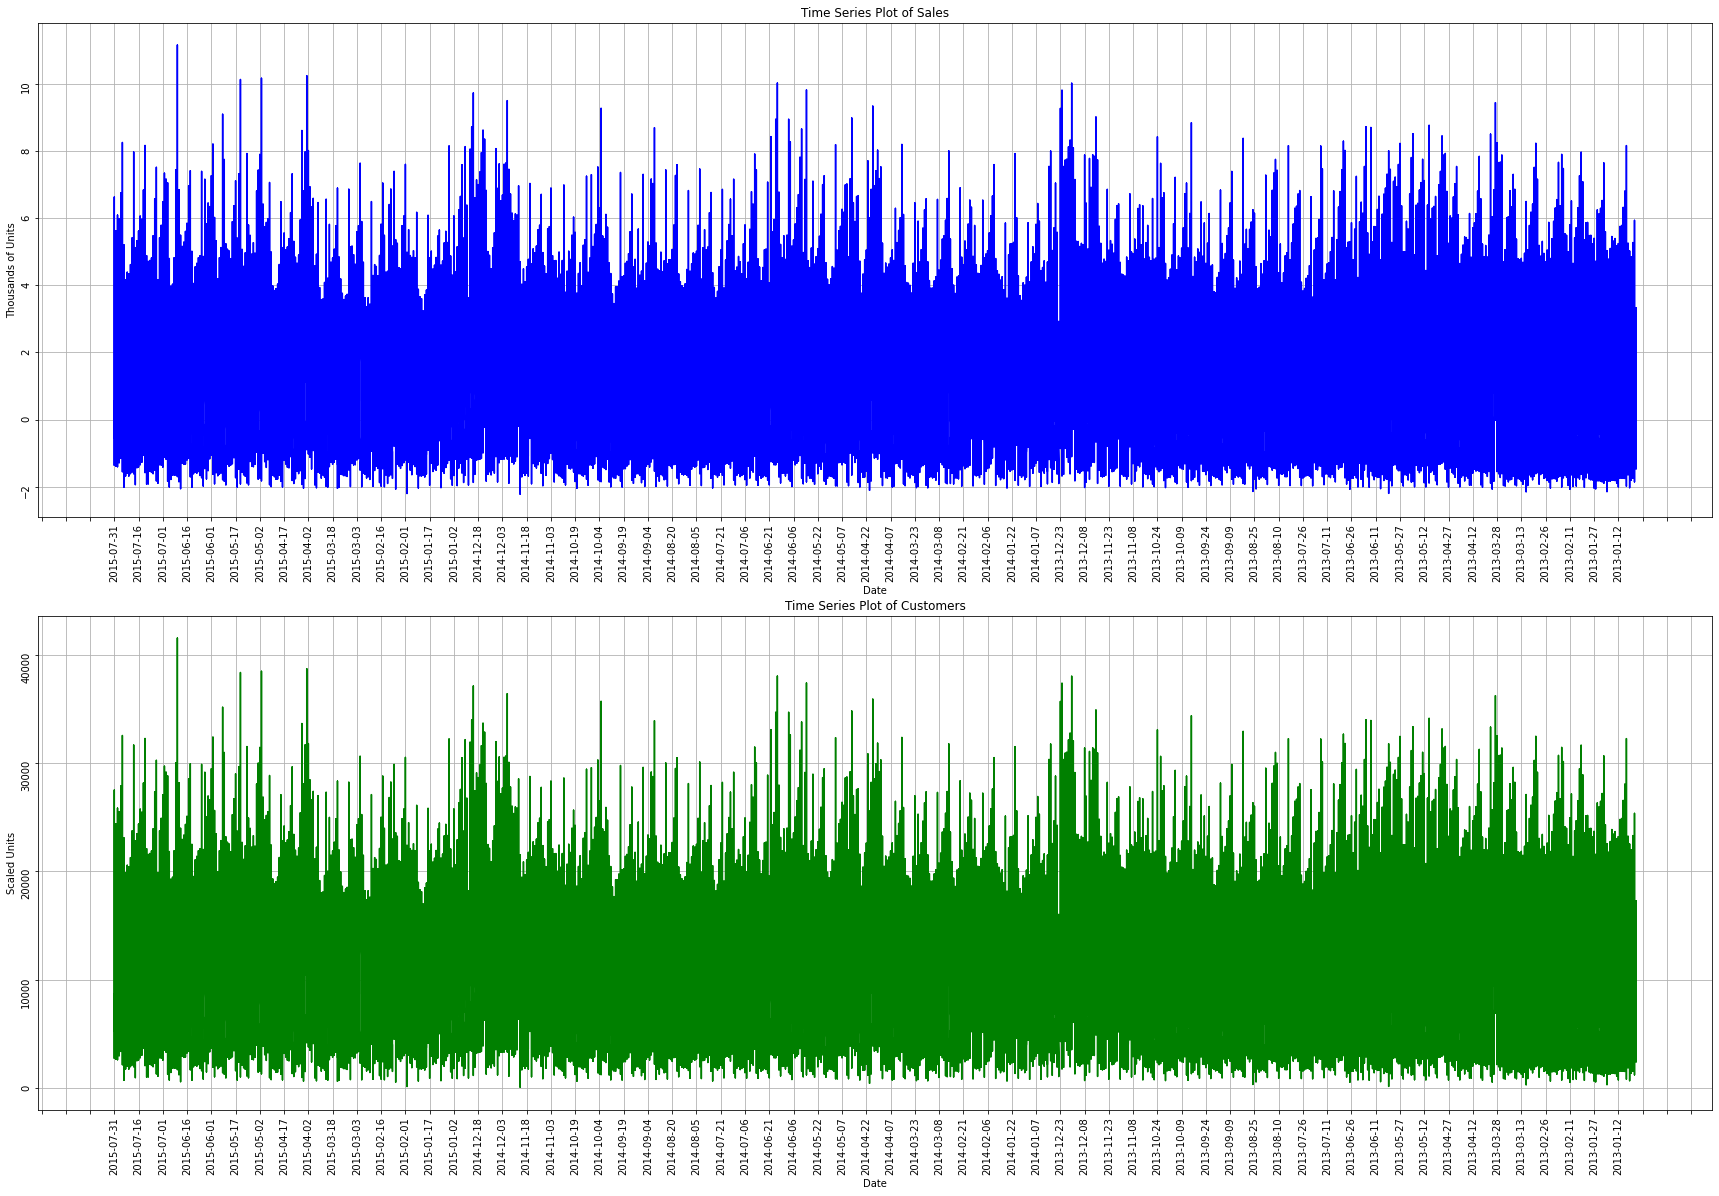

In [ ]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=15)

M = 100
xticks = ticker.MaxNLocator(M)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(scaled_features_df.index, scaled_features_df.Sales, 'b-')
ax1.xaxis.set_major_locator(xticks)
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Thousands of Units')
ax1.title.set_text('Time Series Plot of Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.plot(X.index, X.Sales, 'g-')
ax2.xaxis.set_major_locator(xticks)
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('Date')
ax2.set_ylabel('Scaled Units')
ax2.title.set_text('Time Series Plot of Customers')
ax2.grid(True)
plt.show()

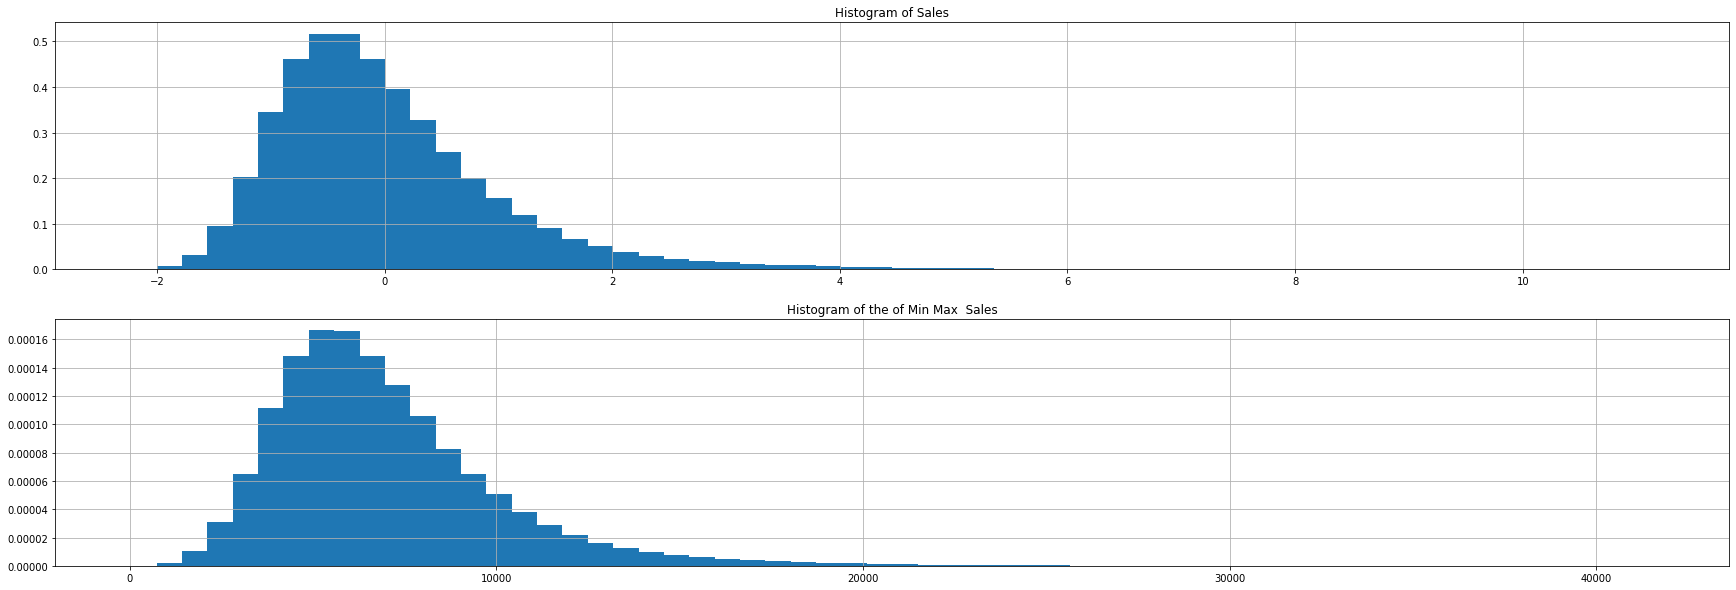

In [ ]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(10)
fig.set_figwidth(30)
fig.tight_layout(pad=6)

ax1 = fig.add_subplot(gs[0,0])
ax1.hist(scaled_features_df.Sales, density=True, bins=60)
ax1.title.set_text('Histogram of Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.hist(X.Sales, density=True, bins=60)
ax2.title.set_text('Histogram of the of Min Max  Sales')
ax2.grid(True)
plt.show()

In [64]:
adfResult = adfuller(scaled_features_df.Sales.values[:100000], autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

ADF Statistic: -9.05093404172353
p-value: 4.842222773138588e-15


In [66]:
adfResult = adfuller(X.Sales.values[:100000], autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

ADF Statistic: -9.050934041723085
p-value: 4.842222773151178e-15


- since the p-value is less than the 0.05 no need for removing stationary step cause it is stationary

In [ ]:
acfSalesScaled = acf(scaled_features_df.Sales.values, fft=True, nlags=40)
acfSalesScaledNp = np.array(acfSalesScaled)

In [ ]:
scaled_features_df.Sales.values.shape

(844338,)

# Auto correlation and partial correlation

In [ ]:
def corrPlots(array: np.array, prefix: str):
    plt.figure(figsize=(30, 5))
    plt.title(f"{prefix}  Autocorrelations of Sales Min Max Scaled")
    plt.bar(range(len(array)), array)
    plt.grid(True)
    plt.show()

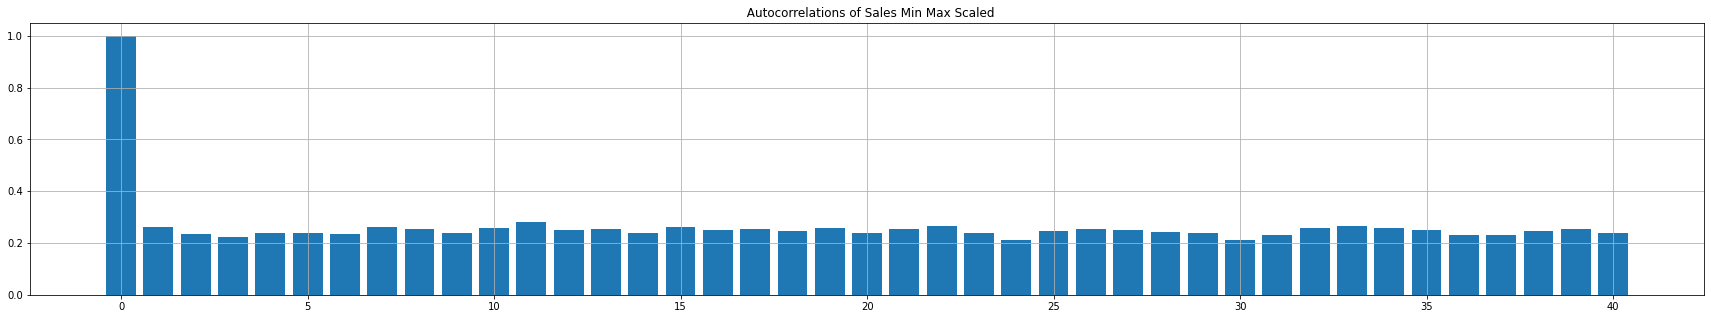

In [ ]:
corrPlots(acfSalesScaledNp, '')

In [ ]:
pacfSalesScaled = pacf(scaled_features_df.Sales.values, nlags=40)
pacfSalesScaledNp = np.array(pacfSalesScaled)

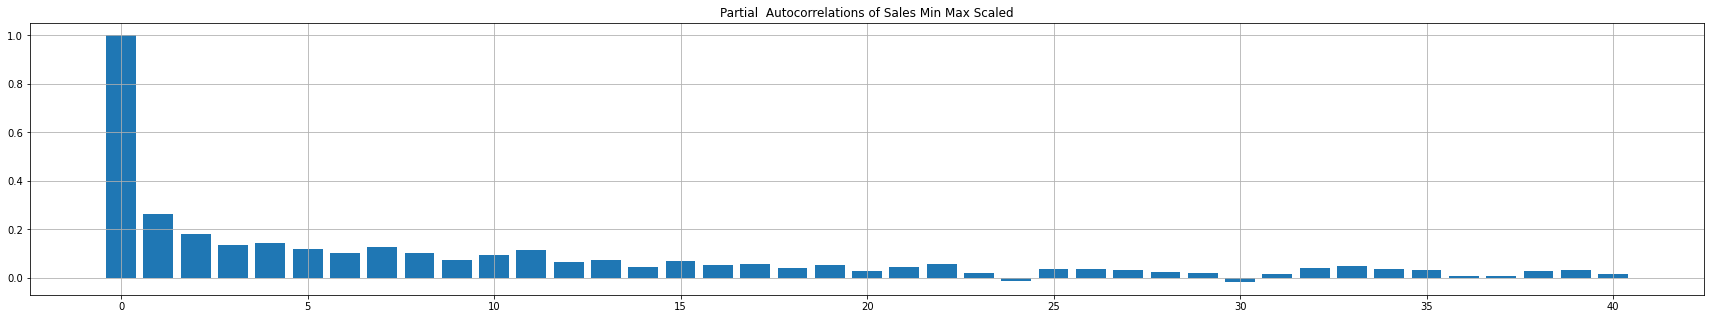

In [ ]:
corrPlots(pacfSalesScaledNp, "Partial")

# turning the time series data into a superviesd model

In [26]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
 


In [ ]:
values = scaled_features_df.values
data = series_to_supervised(values, 1, 1)
print(data)

In [12]:
# split into train and test sets
values = data.values
n_train_days = 365 * 1015
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(370475, 1, 55) (370475,) (473862, 1, 55) (473862,)


In [17]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [18]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 1, 100)            62400     
                                                                 
 lstm_9 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 92,651
Trainable params: 92,651
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(train_X, train_y, epochs=50, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
5789/5789 - 55s - loss: 0.4547 - val_loss: 0.5856 - 55s/epoch - 9ms/step
Epoch 2/50
5789/5789 - 45s - loss: 0.3063 - val_loss: 0.6239 - 45s/epoch - 8ms/step
Epoch 3/50
5789/5789 - 46s - loss: 0.2689 - val_loss: 0.6165 - 46s/epoch - 8ms/step
Epoch 4/50
5789/5789 - 49s - loss: 0.2530 - val_loss: 0.6380 - 49s/epoch - 8ms/step
Epoch 5/50
5789/5789 - 46s - loss: 0.2428 - val_loss: 0.6544 - 46s/epoch - 8ms/step
Epoch 6/50
5789/5789 - 50s - loss: 0.2346 - val_loss: 0.6347 - 50s/epoch - 9ms/step
Epoch 7/50
5789/5789 - 45s - loss: 0.2287 - val_loss: 0.6250 - 45s/epoch - 8ms/step
Epoch 8/50
5789/5789 - 42s - loss: 0.2229 - val_loss: 0.6139 - 42s/epoch - 7ms/step
Epoch 9/50
5789/5789 - 44s - loss: 0.2188 - val_loss: 0.5940 - 44s/epoch - 8ms/step
Epoch 10/50
5789/5789 - 46s - loss: 0.2151 - val_loss: 0.5907 - 46s/epoch - 8ms/step
Epoch 11/50
5789/5789 - 48s - loss: 0.2118 - val_loss: 0.5843 - 48s/epoch - 8ms/step
Epoch 12/50
5789/5789 - 43s - loss: 0.2095 - val_loss: 0.5783 - 43s/epoch 

In [22]:
from datetime import datetime
import pickle
date = datetime.now()
dt_string = str(date.strftime("%d-%m-%Y-%H-%M-%S"))
pickle.dump(model, open('{}.pkl'.format(dt_string), 'wb'))

INFO:tensorflow:Assets written to: ram://f789d1ae-ecf4-4579-8e9d-e51a0c2ba090/assets


INFO:tensorflow:Assets written to: ram://f789d1ae-ecf4-4579-8e9d-e51a0c2ba090/assets


In [ ]:
from tensorflow import keras
model = keras.models.load_model('path/to/location')

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [23]:
date = datetime.now()
dt_string = str(date.strftime("%d-%m-%Y-%H-%M-%S"))
model.save('model.{}'.format(dt_string))

INFO:tensorflow:Assets written to: model.27-05-2022-12-03-25/assets


INFO:tensorflow:Assets written to: model.27-05-2022-12-03-25/assets


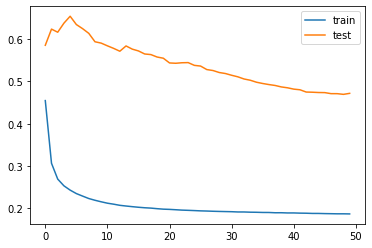

In [27]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## the model is we can see is overfitting if we could let the epochs rum for a little more we might get better result cause the validation results were decreasing on each step

# Time-Series Analysis per Store Type

- to visulaize and for faster training

In [5]:
train_store['date'] = pd.to_datetime(train_store[['Day', 'Month', 'Year']], format='%Y%m%d')
train_store['date'] = pd.to_datetime(train_store.date.dt.strftime('%Y-%m-%d'))
# train_store['date'] = pd.DatetimeIndex(train_store['date'])
# train_store['date'].to_frame(index = True)
df = train_store.set_index(['date'])
df.drop('Unnamed: 0', axis = 1, inplace=True)
df.isna().sum()

Store                        0
DayOfWeek                    0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
Year                         0
Month                        0
Day                          0
WeekOfYear                   0
SalePerCustomer              0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

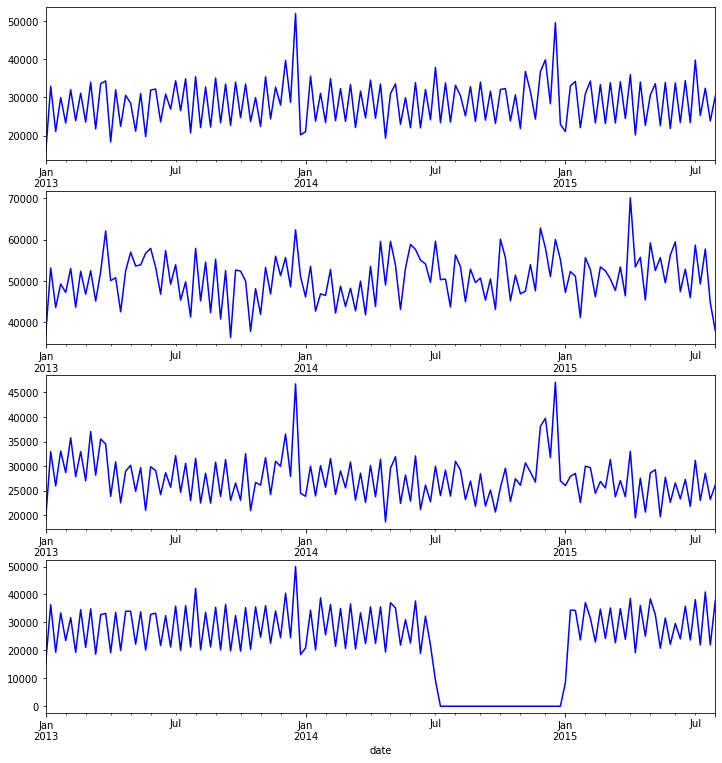

In [6]:
# preparation: input should be float type
df['Sales'] = df['Sales'] * 1.0

# store types choosen at random
sales_a = df[df.Store == 2]['Sales']
sales_b = df[df.Store == 85]['Sales'].sort_index(ascending = True) # solve the reverse order
sales_c = df[df.Store == 1]['Sales']
sales_d = df[df.Store == 13]['Sales']

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# store types
sales_a.resample('W').sum().plot(color = 'blue', ax = ax1)
sales_b.resample('W').sum().plot(color = 'blue', ax = ax2)
sales_c.resample('W').sum().plot(color = 'blue', ax = ax3)
sales_d.resample('W').sum().plot(color = 'blue', ax = ax4)

- it shows there is a seasonal trend on christmas

# seasonal Trend

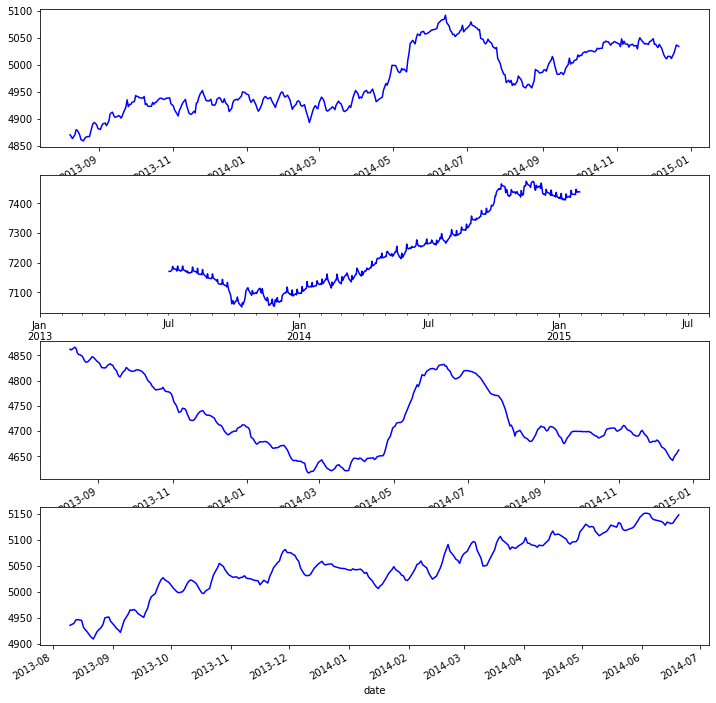

In [54]:
from statsmodels.tsa.seasonal import seasonal_decompose
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# monthly
decomposition_a = seasonal_decompose(sales_a, model = 'additive', freq = 365)
decomposition_a.trend.plot(color = 'blue', ax = ax1)

decomposition_b = seasonal_decompose(sales_b, model = 'additive', freq = 365)
decomposition_b.trend.plot(color = 'blue', ax = ax2)

decomposition_c = seasonal_decompose(sales_c, model = 'additive', freq = 365)
decomposition_c.trend.plot(color = 'blue', ax = ax3)

decomposition_d = seasonal_decompose(sales_d, model = 'additive', freq = 365)
decomposition_d.trend.plot(color = 'blue', ax = ax4)

- for all store type there is increase in sales except for store type c

# Autocorrelaion and Partial Autocorrelation

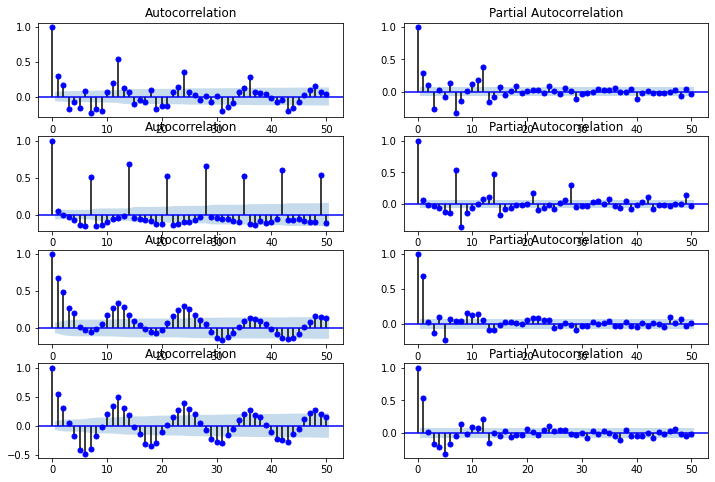

In [55]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# figure for subplots
plt.figure(figsize = (12, 8))

# acf and pacf for A
plt.subplot(421); plot_acf(sales_a, lags = 50, ax = plt.gca(), color = 'blue')
plt.subplot(422); plot_pacf(sales_a, lags = 50, ax = plt.gca(), color = 'blue')

# acf and pacf for B
plt.subplot(423); plot_acf(sales_b, lags = 50, ax = plt.gca(), color = 'blue')
plt.subplot(424); plot_pacf(sales_b, lags = 50, ax = plt.gca(), color = 'blue')

# acf and pacf for C
plt.subplot(425); plot_acf(sales_c, lags = 50, ax = plt.gca(), color = 'blue')
plt.subplot(426); plot_pacf(sales_c, lags = 50, ax = plt.gca(), color = 'blue')

# acf and pacf for D
plt.subplot(427); plot_acf(sales_d, lags = 50, ax = plt.gca(), color = 'blue')
plt.subplot(428); plot_pacf(sales_d, lags = 50, ax = plt.gca(), color = 'blue')

plt.show()

In [19]:
# df = df.query(df.Store == 2 or df.Store == 13 or df.store == 85 or df.store == 13)
rows = [2,13,85,13]
df = df[df["Store"].isin(rows)]

In [20]:
X, col = pre_processing(df)
values = X.values
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

- trying to predict 6 weeks ahead 

In [27]:
n_days = 7*6
n_features = 1
# values = scaled.values
# frame as supervised learning
reframed = series_to_supervised(scaled, n_days, 1)
print(reframed.shape)

(2305, 989)


In [38]:
reframed.drop(reframed.columns[-23:-1], axis=1, inplace=True)

In [39]:
reframed.head()

,var1(t-42),var2(t-42),var3(t-42),var4(t-42),var5(t-42),var6(t-42),var7(t-42),var8(t-42),var9(t-42),var10(t-42),...,var15(t-1),var16(t-1),var17(t-1),var18(t-1),var19(t-1),var20(t-1),var21(t-1),var22(t-1),var23(t-1),var23(t)
42,-1.00000,0.333333,-1.0,1.0,-1.0,1.0,1.0,0.090909,1.000000,0.176471,...,-0.422222,1.000000,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-0.533229,-0.405658
43,-0.73494,0.333333,-1.0,1.0,-1.0,-1.0,1.0,0.090909,1.000000,0.176471,...,1.000000,0.999005,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-0.405658,-0.247642
44,1.00000,0.333333,-1.0,1.0,-1.0,1.0,1.0,0.090909,1.000000,0.176471,...,-1.000000,-1.000000,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-0.247642,-0.333630
45,-1.00000,0.000000,-1.0,1.0,-1.0,1.0,1.0,0.090909,0.933333,0.176471,...,-0.422222,1.000000,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-0.333630,0.249722
46,-0.73494,0.000000,-1.0,1.0,-1.0,-1.0,1.0,0.090909,0.933333,0.176471,...,1.000000,0.999005,-1.0,-1.0,1.0,-1.0,1.0,-1.0,0.249722,-0.174723


In [54]:
values = reframed.values
n_train_days = 365 * 5
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
# n_obs = n_days * n_features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, 23))
test_X = test_X.reshape((test_X.shape[0], n_days, 23))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1825, 966) 1825 (1825,)
(1825, 42, 23) (1825,) (480, 42, 23) (480,)


In [45]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 42, 50)            14800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               60400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 75,301
Trainable params: 75,301
Non-trainable params: 0
_________________________________________________________________


In [55]:
history = model.fit(train_X, train_y, epochs=25, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/25
26/26 - 4s - loss: 0.0776 - val_loss: 0.1211 - 4s/epoch - 143ms/step
Epoch 2/25
26/26 - 2s - loss: 0.0738 - val_loss: 0.1055 - 2s/epoch - 94ms/step
Epoch 3/25
26/26 - 2s - loss: 0.0795 - val_loss: 0.1024 - 2s/epoch - 91ms/step
Epoch 4/25
26/26 - 2s - loss: 0.0881 - val_loss: 0.0860 - 2s/epoch - 91ms/step
Epoch 5/25
26/26 - 2s - loss: 0.0948 - val_loss: 0.0978 - 2s/epoch - 92ms/step
Epoch 6/25
26/26 - 2s - loss: 0.0942 - val_loss: 0.0904 - 2s/epoch - 92ms/step
Epoch 7/25
26/26 - 2s - loss: 0.0752 - val_loss: 0.0839 - 2s/epoch - 93ms/step
Epoch 8/25
26/26 - 2s - loss: 0.0755 - val_loss: 0.0907 - 2s/epoch - 94ms/step
Epoch 9/25
26/26 - 2s - loss: 0.0714 - val_loss: 0.0909 - 2s/epoch - 92ms/step
Epoch 10/25
26/26 - 2s - loss: 0.0726 - val_loss: 0.0974 - 2s/epoch - 93ms/step
Epoch 11/25
26/26 - 2s - loss: 0.0732 - val_loss: 0.1055 - 2s/epoch - 93ms/step
Epoch 12/25
26/26 - 2s - loss: 0.0725 - val_loss: 0.0869 - 2s/epoch - 92ms/step
Epoch 13/25
26/26 - 2s - loss: 0.0767 - val_loss

In [48]:
from datetime import datetime
import pickle
date = datetime.now()
dt_string = str(date.strftime("%d-%m-%Y-%H-%M-%S"))
pickle.dump(model, open('{}.pkl'.format(dt_string), 'wb'))
model.save('{}-keras'.format(dt_string))

INFO:tensorflow:Assets written to: ram://e8a284f0-ede1-4a95-ac55-97fbe6196c1d/assets


INFO:tensorflow:Assets written to: ram://e8a284f0-ede1-4a95-ac55-97fbe6196c1d/assets


INFO:tensorflow:Assets written to: 27-05-2022-14-55-46-keras/assets


INFO:tensorflow:Assets written to: 27-05-2022-14-55-46-keras/assets


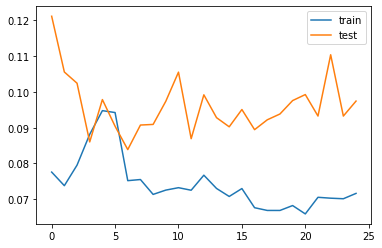

In [56]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()